<a href="https://colab.research.google.com/github/sojinleeme/DFE604-2021F/blob/master/%EA%B0%80%EC%83%81%EA%B3%B5%ED%95%99_%EC%8B%A4%EC%8A%B5_2022_11_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [220]:
import scipy.io
import pandas as pd
# mat = scipy.io.loadmat('wine.mat') # 데이터 129개밖에 안되서 탈락 
# mat = scipy.io.loadmat('shuttle.mat') 
# mat = scipy.io.loadmat('cardio.mat') 
# mat = scipy.io.loadmat('thyroid.mat') 
mat = scipy.io.loadmat('breastw.mat') 
mat = {k:v for k, v in mat.items() if k[0] != '_'}
print(mat.keys()) # X = Multi-dimensional point data, y = labels (1 = outliers, 0 = inliers)
print("All dataset: {}".format(len(mat['y'])))

dict_keys(['X', 'y'])
All dataset: 683


In [248]:
normal_data_index = [i for i in range(len(mat['y'])) if mat['y'][i] == 0]
abnormal_data_index = [i for i in range(len(mat['y'])) if mat['y'][i] == 1]
print("normal data: {}".format(len(normal_data_index)))
print("abnormal data: {}".format(len(abnormal_data_index)))

normal data: 444
abnormal data: 239


In [249]:
dataframe_X = pd.DataFrame(mat['X'])
dataframe_y = pd.DataFrame(mat['y'])

normal_data_X = dataframe_X.iloc[normal_data_index]
fraud_data_X = dataframe_X.iloc[abnormal_data_index]
normal_data_y = dataframe_y.iloc[normal_data_index]
fraud_data_y = dataframe_y.iloc[abnormal_data_index]

print(len(normal_data_X))
print(len(fraud_data_X))
print(len(normal_data_y))
print(len(fraud_data_y))

444
239
444
239


In [260]:
from sklearn.model_selection import train_test_split

# Split train and test
X_train, X_test, y_train, y_test = train_test_split(normal_data_X,normal_data_y,test_size=0.1,random_state=34)
print(len(y_test))

45


In [266]:
X_test = (X_test.append(fraud_data_X,sort=False)).sort_index()
y_test = (y_test.append(fraud_data_y,sort=False)).sort_index()

In [267]:
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import KernelDensity, LocalOutlierFactor


# Model
# num_mixture = 1 # for multivariate gaussian model
# MultiG = GaussianMixture(n_components= num_mixture, random_state=0, covariance_type='full')

num_mixture = 100 # for GMM
GMM = GaussianMixture(n_components=num_mixture, random_state=42, covariance_type='diag')

IForest = IsolationForest(max_samples=3, contamination = 'auto', random_state=0)

band_width = 0.001
KDE = KernelDensity(kernel='gaussian', bandwidth=band_width)

n_neighbors = 5
LOF = LocalOutlierFactor(n_neighbors=n_neighbors, contamination="auto", novelty = True)

# Concat models
# models = [MultiG, GMM, IForest, KDE, LOF]
models = [GMM, IForest, KDE, LOF]

In [264]:

import matplotlib.pyplot as plt

# Function for visualization
def roc_auc(labels, scores, defect_name = None, save_path = None):
        fpr, tpr, _ = roc_curve(labels, scores, pos_label=0)
        roc_auc = auc(fpr, tpr)

        plt.title(f'ROC curve: {defect_name}')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')

        plt.show()
        return roc_auc

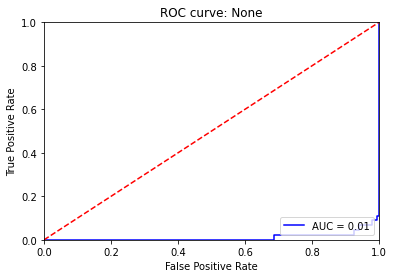

roc_auc_score: 1.0506741050674104


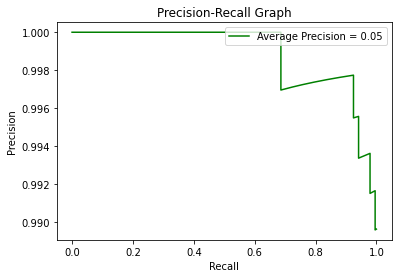

average_precision: 4.644353266514663


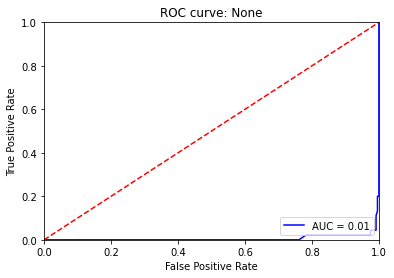

roc_auc_score: 0.6601580660158064


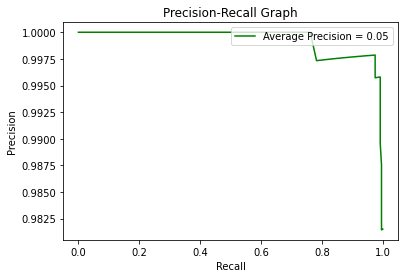

average_precision: 4.8055481908404145


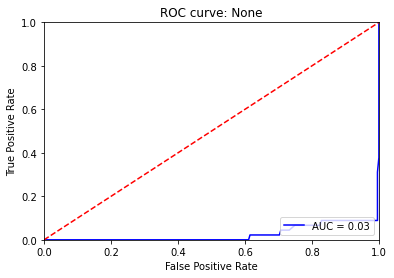

roc_auc_score: 2.584844258484425


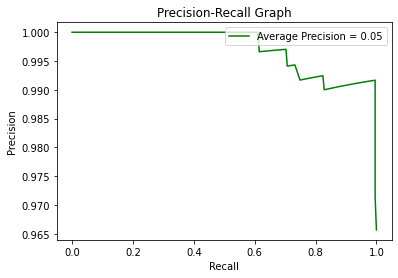

average_precision: 4.711480554211423


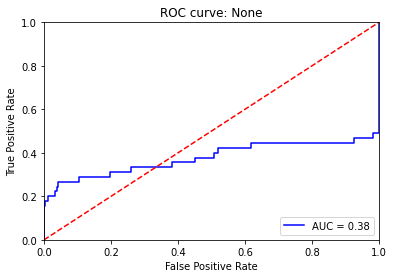

roc_auc_score: 37.61041376104138


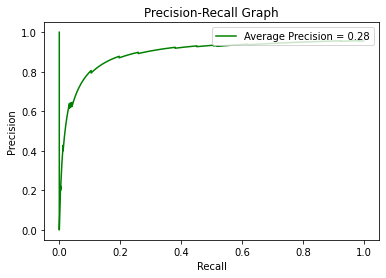

average_precision: 27.576244354911655


In [265]:

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Evaluate models
for model in models:
    
    model.fit(X_train)
    y_test_score = -model.score_samples(X_test)
    
    # Calculate ROC AUC
    print('roc_auc_score:' , format(roc_auc(y_test, y_test_score)*100))
    
    # Precision and recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_test_score, pos_label=1)
        
    # Calculate average precision
    average_precision = average_precision_score(y_test, y_test_score, pos_label=0, average = 'samples')

    plt.title("Precision-Recall Graph")

    plt.xlabel("Recall"   )
    plt.ylabel("Precision")

    plt.plot(recall, precision, "g", label = "Average Precision = %0.2F" % average_precision)

    plt.legend(loc = "upper right")

    plt.show()

    print('average_precision:' , format(average_precision*100))